- pretraining with tiny person
- test with water data

In [2]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pandas as pd

from PIL import Image
import ast
import json
from glob import glob

In [3]:
is_dense_only = True

dense : m 49
sparse : m 717

In [5]:
folder_water_image = '/home/sogangori/Downloads/water/'
os.path.isdir(folder_water_image)

True

In [8]:
img_paths = glob(folder_water_image + '*.*')
len(img_paths)

96

In [11]:
water_images = []
for img_path in img_paths:
    img = Image.open(img_path)
    water_images.append(np.array(img))
len(water_images), water_images[0].shape     

(96, (1080, 1920, 3))

In [12]:
path_tiny = '/home/sogangori/Downloads/tiny_set/'
path_tiny_certain_train = path_tiny + 'erase_with_uncertain_dataset/train/'
path_tiny_certain_test = path_tiny + 'erase_with_uncertain_dataset/test/'

In [13]:
#path_tiny_annotation = path_tiny + 'annotations/tiny_set_train.json'
path_tiny_dense_annotation = path_tiny + 'annotations/tiny_set_train_with_dense.json'
path_tiny_sparse_annotation = path_tiny + 'annotations/tiny_set_train.json'
path_tiny_dense_annotation, path_tiny_sparse_annotation

('/home/sogangori/Downloads/tiny_set/annotations/tiny_set_train_with_dense.json',
 '/home/sogangori/Downloads/tiny_set/annotations/tiny_set_train.json')

In [14]:
os.path.isfile(path_tiny_sparse_annotation), os.path.isfile(path_tiny_dense_annotation)

(True, True)

In [15]:
with open(path_tiny_dense_annotation, 'r') as j:
    contents = json.loads(j.read())                    

In [16]:
len(contents), contents.keys()

(4, dict_keys(['type', 'annotations', 'images', 'categories']))

In [17]:
images = contents['images']
annotations = contents['annotations']
print(len(images), type(images), images[:2])
print(len(annotations), type(annotations), annotations[0])

794 <class 'list'> [{'file_name': 'labeled_images/bb_V0032_I0001640.jpg', 'height': 720, 'width': 1280, 'id': 0}, {'file_name': 'labeled_images/bb_V0014_I0002600.jpg', 'height': 1080, 'width': 1920, 'id': 1}]
42197 <class 'list'> {'segmentation': [[1081.124389319407, 17.45930926910859, 1267.431666947439, 17.45930926910859, 1267.431666947439, 67.73270164492683, 1081.124389319407, 67.73270164492683]], 'bbox': [1081.124389319407, 17.45930926910859, 186.3072776280319, 50.27339237581825], 'category_id': 1, 'area': 9366.298870664552, 'iscrowd': 0, 'image_id': 0, 'id': 0, 'ignore': True, 'uncertain': False, 'logo': True, 'in_dense_image': False}


In [18]:
file_name_id_dict = dict()
for image in images:
    file_name = image['file_name']
    id_num = image['id']
    target = 'labeled'
    if is_dense_only:
        target = 'dense'    
    if target in file_name:
        file_name_id_dict[file_name] = id_num

In [19]:
id_values = file_name_id_dict.values()
len(id_values), len(set(id_values)), min(id_values), max(id_values)

(48, 48, 717, 764)

In [20]:
id_bbox_dict = dict()
for annotation in annotations:    
    image_id = annotation['image_id']
    category_id = annotation['category_id'] # 1:human on sea, 2: human on land  ?
    bbox = annotation['bbox']
    ignore = annotation['ignore']
    uncertain = annotation['uncertain']    
        
    bbox = np.array(bbox, dtype=np.int)
    x, y, w, h = bbox
    if w*h<2*2:
        print('tiny',image_id, bbox)
        
    if False:
        margin = int(np.sqrt(w))
        margin = min(margin, 4)
        #print('w', w, 'margin',margin)
        x -= margin
        y -= margin
        h += margin * 2
        w += margin * 2
    bbox = [y, x, y+h, x+w]
    #print('bbox', bbox)
    #break
    
    if ignore or uncertain:
        #print(image_id, bbox, ignore, uncertain)
        pass
    else:
        if image_id in id_bbox_dict.keys():
            id_bbox_dict[image_id].extend(bbox)
        else:
            id_bbox_dict[image_id] = bbox

In [21]:
np.array(id_bbox_dict[1]).reshape([-1, 4]).shape

(80, 4)

In [22]:
path_tiny_certain_train, path_tiny_certain_test

('/home/sogangori/Downloads/tiny_set/erase_with_uncertain_dataset/train/',
 '/home/sogangori/Downloads/tiny_set/erase_with_uncertain_dataset/test/')

In [71]:
input_list_all = []
bbox_list_all = []

for file_name in file_name_id_dict.keys():
    file_full_path_train = path_tiny_certain_train + file_name
    file_full_path_test = path_tiny_certain_test + file_name
    
    file_id = file_name_id_dict[file_name]
    if not file_id in id_bbox_dict.keys():
        continue
    bboxes = id_bbox_dict[file_id]
    bboxes_2d = np.reshape(bboxes, [-1, 4])
        
    if os.path.isfile(file_full_path_train):
        img = Image.open(file_full_path_train)
        img_arr = np.array(img)
                
        h, w, c = img_arr.shape
        scale = np.array((h, w, h, w))
        scale = np.reshape(scale, (1, 4))
        bbox_norm = bboxes_2d.astype(np.float) / scale.astype(np.float)
        cls = np.ones_like(bbox_norm[:, :1])
        cls_bbox_norm = np.concatenate((cls, bbox_norm), axis=1)
        
        input_list_all.append(img_arr)
        bbox_list_all.append(cls_bbox_norm)    
        if len(input_list_all)%100==0:
            print('reading image', len(file_name_id_dict.keys()), len(input_list_all))
        elif os.path.isfile(file_full_path_test):        
            continue
    #if len(input_list)==10: break
        
print('input_list_all', len(input_list_all), len(bbox_list_all))

input_list_all 47 47


In [72]:
def split_image_9_block(img_arr, cbboxs):
    #arr : (h, w, c)
    #cbboxs : (k, (cls, y0, x0, y1, x1))
    h, w, c = img_arr.shape
    if h%3!=0:
        img_arr = img_arr[h%3:]
    if w%3!=0:
        img_arr = img_arr[:, w%3:]
    h, w, c = img_arr.shape
    
    img0, img1, img2 = np.split(img_arr, 3, axis=0)
    img00, img01, img02 = np.split(img0, 3, axis=1)
    img10, img11, img12 = np.split(img1, 3, axis=1)
    img20, img21, img22 = np.split(img1, 3, axis=1)
    bboxs = cbboxs[:, 1:]
    cy = (bboxs[:, 0] + bboxs[:, 2])/2
    cx = (bboxs[:, 1] + bboxs[:, 3])/2
    thresh = 1.0/3.0
    mask00 = np.logical_and(cy < thresh, cx < thresh)
    mask01 = np.logical_and(cy < thresh, np.logical_and(cx >= thresh, cx < thresh*2))
    mask02 = np.logical_and(cy < thresh, cx >= thresh * 2)
    mask10 = np.logical_and(np.logical_and(cy >= thresh, cy < thresh*2), 
                            cx < thresh)
    mask11 = np.logical_and(np.logical_and(cy >= thresh, cy < thresh*2), 
                            np.logical_and(cx >= thresh, cx < thresh*2))
    mask12 = np.logical_and(np.logical_and(cy >= thresh, cy < thresh*2), 
                            cx >= thresh*2)
    mask20 = np.logical_and(cy > thresh*2, cx < thresh)
    mask21 = np.logical_and(cy > thresh*2, np.logical_and(cx >= thresh, cx < thresh*2))
    mask22 = np.logical_and(cy > thresh*2, cx >= thresh * 2)
        
    img_split = []
    bbox_split = []
    
    if np.any(mask00):
        box = cbboxs[mask00]
        cbox = np.stack((box[:, 0], box[:, 1]*3, box[:, 2]*3, box[:, 3]*3, box[:, 4]*3), axis=1)        
        img_split.append(img00)
        bbox_split.append(cbox)
    if np.any(mask01):
        box = cbboxs[mask01]
        cbox = np.stack((box[:, 0], box[:, 1]*3, (box[:, 2]-thresh)*3, box[:, 3]*3, (box[:, 4]-thresh)*3), axis=1)
        img_split.append(img01)
        bbox_split.append(cbox)
    if np.any(mask02):
        box = cbboxs[mask02]
        cbox = np.stack((box[:, 0], box[:, 1]*3, (box[:, 2]-thresh*2)*3, box[:, 3]*3, (box[:, 4]-thresh*2)*3), axis=1)
        img_split.append(img02)
        bbox_split.append(cbox)
    if np.any(mask10):
        box = cbboxs[mask10]
        cbox = np.stack((box[:, 0], (box[:, 1]-thresh)*3, box[:, 2]*3, (box[:, 3]-thresh)*3, box[:, 4]*3), axis=1)        
        img_split.append(img10)
        bbox_split.append(cbox)
    if np.any(mask11):
        box = cbboxs[mask11]
        cbox = np.stack((box[:, 0], (box[:, 1]-thresh)*3, (box[:, 2]-thresh)*3, (box[:, 3]-thresh)*3, (box[:, 4]-thresh)*3), axis=1)        
        img_split.append(img11)
        bbox_split.append(cbox)
    if np.any(mask12):
        box = cbboxs[mask12]
        cbox = np.stack((box[:, 0], (box[:, 1]-thresh)*3, (box[:, 2]-thresh*2)*3, (box[:, 3]-thresh)*3, (box[:, 4]-thresh*2)*3), axis=1)        
        img_split.append(img12)
        bbox_split.append(cbox)
    if np.any(mask20):
        box = cbboxs[mask20]
        cbox = np.stack((box[:, 0], (box[:, 1]-thresh*2)*3, box[:, 2]*3, (box[:, 3]-thresh*2)*3, box[:, 4]*3), axis=1)        
        img_split.append(img20)
        bbox_split.append(cbox)
    if np.any(mask21):
        box = cbboxs[mask21]
        cbox = np.stack((box[:, 0], (box[:, 1]-thresh*2)*3, (box[:, 2]-thresh)*3, (box[:, 3]-thresh*2)*3, (box[:, 4]-thresh)*3), axis=1)        
        img_split.append(img21)
        bbox_split.append(cbox)
    if np.any(mask22):
        box = cbboxs[mask22]
        cbox = np.stack((box[:, 0], (box[:, 1]-thresh*2)*3, (box[:, 2]-thresh*2)*3, (box[:, 3]-thresh*2)*3, (box[:, 4]-thresh*2)*3), axis=1)        
        img_split.append(img22)
        bbox_split.append(cbox)
    
    return img_split, bbox_split

In [73]:
def split_image_4_block(img_arr, cbboxs):
    #arr : (h, w, c)
    #cbboxs : (k, (cls, y0, x0, y1, x1))
    h, w, c = img_arr.shape
    if h%2!=0:
        img_arr = img_arr[1:]
    if w%2!=0:
        img_arr = img_arr[:, 1:]
    h, w, c = img_arr.shape
    
    img0, img1 = np.split(img_arr, 2, axis=0)
    img00, img01 = np.split(img0, 2, axis=1)
    img10, img11 = np.split(img1, 2, axis=1)
    bboxs = cbboxs[:, 1:]
    cy = (bboxs[:, 0] + bboxs[:, 2])/2
    cx = (bboxs[:, 1] + bboxs[:, 3])/2
    mask00 = np.logical_and(cy < 0.5, cx < 0.5)
    mask01 = np.logical_and(cy < 0.5, cx >= 0.5)
    mask10 = np.logical_and(cy >= 0.5, cx < 0.5)
    mask11 = np.logical_and(cy >= 0.5, cx >= 0.5)
        
    img_split = []
    bbox_split = []
    
    if np.any(mask00):
        box = cbboxs[mask00]
        cbox = np.stack((box[:, 0], box[:, 1]*2, box[:, 2]*2, box[:, 3]*2, box[:, 4]*2), axis=1)
        #box_area = np.mean(np.sqrt(np.prod(cbox[:, 3:5] - cbox[:, 1:3], axis=1)), 1)
        #print('box_area', box_area)
        img_split.append(img00)
        bbox_split.append(cbox)
    if np.any(mask01):
        box = cbboxs[mask01]
        cbox = np.stack((box[:, 0], box[:, 1]*2, (box[:, 2]-0.5)*2, box[:, 3]*2, (box[:, 4]-0.5)*2), axis=1)
        img_split.append(img01)
        bbox_split.append(cbox)
    if np.any(mask10):
        box = cbboxs[mask10]
        cbox = np.stack((box[:, 0], (box[:, 1]-0.5)*2, box[:, 2]*2, (box[:, 3]-0.5)*2, box[:, 4]*2), axis=1)
        img_split.append(img10)
        bbox_split.append(cbox)
    if np.any(mask11):
        box = cbboxs[mask11]
        cbox = np.stack((box[:, 0], (box[:, 1]-0.5)*2, (box[:, 2]-0.5)*2, (box[:, 3]-0.5)*2, (box[:, 4]-0.5)*2), axis=1)
        img_split.append(img11)
        bbox_split.append(cbox)
    
    return img_split, bbox_split

In [74]:
input_list = []
bbox_list = []
np.set_printoptions(3)
for i in range(len(input_list_all)):
    img_arr = input_list_all[i]
    cbboxs = bbox_list_all[i]
    bbox_norm = cbboxs[:, 1:]
    bbox_norm_width = bbox_norm[:, 3] - bbox_norm[:, 1]
    bbox_norm_width_max = np.max(bbox_norm_width, axis=0)
    bbox_norm_width_min = np.min(bbox_norm_width, axis=0)
    bbox_norm_width_mean = np.mean(bbox_norm_width, axis=0)
    #print('img_arr', img_arr.shape, cbboxs.shape, bbox_norm_width_min, bbox_norm_width_max)
    h, w, c = img_arr.shape
    #if w > 2000 or (bbox_norm_width_min<0.002 and bbox_norm_width_max<0.015): 
    if w > 2000:
        img_split, bbox_split = split_image_4_block(img_arr, cbboxs)
        input_list.extend(img_split)
        bbox_list.extend(bbox_split)
    elif bbox_norm_width_mean<0.004:
        img_split, bbox_split = split_image_4_block(img_arr, cbboxs)
        input_list.extend(img_split)
        bbox_list.extend(bbox_split)        
    else:
        input_list.append(img_arr)
        bbox_list.append(cbboxs)

print('input_list', len(input_list_all), len(input_list))

input_list 47 107


In [75]:
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    img_h, img_w, img_c = image.shape
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 3] - boxes[:, 1]
    boxes_height = boxes[:, 2] - boxes[:, 0]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, width:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width))
    plt.title(title)
    for box, cls in zip(boxes, classes):
        y1, x1, y2, x2 = box        
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        
    plt.show()
    return ax

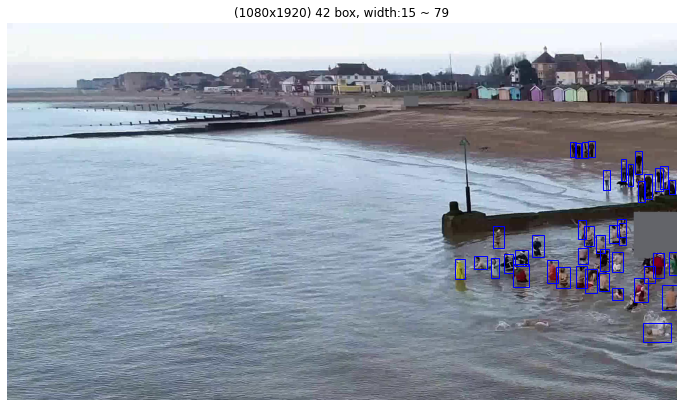

In [76]:
for i in range(len(input_list)):
    img_arr = input_list[i]
    sample_box = bbox_list[i]
    label = np.ones_like(sample_box[:, 0])
    bbox = sample_box[:, 1:]

    h, w, c = img_arr.shape
    #if w<2000: continue
    scale = np.array((h, w, h, w), dtype=np.float)
    scale = np.reshape(scale, (1, 4))
    bbox_norm = bbox.astype(np.float) * scale
    #print('bbox_norm', bbox, bbox_norm)
    ax = visualize_detections_simple(img_arr,bbox_norm,label)
    break

In [77]:
WATER_CLASSES = ['bg', 'human']
num_classes = len(WATER_CLASSES)
l1 = 0.00001

In [78]:
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.
    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.
    Returns:
      swapped boxes with shape same as that of boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates
    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.
    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )


"""
## Computing pairwise Intersection Over Union (IOU)
As we will see later in the example, we would be assigning ground truth boxes
to anchor boxes based on the extent of overlapping. This will require us to
calculate the Intersection Over Union (IOU) between all the anchor
boxes and ground truth boxes pairs.
"""

#compute_iou(anchor_boxes, gt_boxes)
def compute_iou(boxes1, boxes2):
    """Computes pairwise IOU matrix for given two sets of boxes
    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


def visualize_detections(
    image, boxes, classes, scores, figsize=(10, 10), linewidth=1, color=[0, 0, 1], 
    boxes_gt=None):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()    
         
    if boxes_gt is not None:
        for box in boxes_gt:        
            #x1, y1, x2, y2 = box
            y1, x1, y2, x2 = box
            w, h = x2 - x1, y2 - y1
            patch = plt.Rectangle(
                [x1, y1], w, h, fill=False, edgecolor=[0,1,0], linewidth=linewidth
            )
            ax.add_patch(patch)
            
    for box, _cls, score in zip(boxes, classes, scores):
        #text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
   
        
    plt.show()
    return ax


"""
## Implementing Anchor generator
Anchor boxes are fixed sized boxes that the model uses to predict the bounding
box for an object. It does this by regressing the offset between the location
of the object's center and the center of an anchor box, and then uses the width
and height of the anchor box to predict a relative scale of the object. In the
case of RetinaNet, each location on a given feature map has nine anchor boxes
(at three scales and three ratios).
"""


class AnchorBox:
    """Generates anchor boxes.
    This class has operations to generate anchor boxes for feature maps at
    strides `[8, 16, 32, 64, 128]`. Where each anchor each box is of the
    format `[x, y, width, height]`.
    Attributes:
      aspect_ratios: A list of float values representing the aspect ratios of
        the anchor boxes at each location on the feature map
      scales: A list of float values representing the scale of the anchor boxes
        at each location on the feature map.
      num_anchors: The number of anchor boxes at each location on feature map
      areas: A list of float values representing the areas of the anchor
        boxes for each feature map in the feature pyramid.
      strides: A list of float value representing the strides for each feature
        map in the feature pyramid.
    """

    def __init__(self):
        #self.aspect_ratios = [0.5, 1.0, 2.0]        
        #self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]
        self.aspect_ratios = [1.0]        
        self.scales = [2 ** x for x in [0]]
                
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        #self._strides = [2 ** i for i in range(3, 8)]
        #self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._strides = [2 ** i for i in range(3, 7)]
        #self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0]]
        self._areas = [x ** 2 for x in [16.0, 32.0, 64.0, 128.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        """Computes anchor box dimensions for all ratios and scales at all levels
        of the feature pyramid.
        """
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """Generates anchor boxes for a given feature map size and level
        Arguments:
          feature_height: An integer representing the height of the feature map.
          feature_width: An integer representing the width of the feature map.
          level: An integer representing the level of the feature map in the
            feature pyramid.
        Returns:
          anchor boxes with the shape
          `(feature_height * feature_width * num_anchors, 4)`
        """
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.
        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.
        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 7)
        ]
        return tf.concat(anchors, axis=0)


"""
## Preprocessing data
Preprocessing the images involves two steps:
- Resizing the image: Images are resized such that the shortest size is equal
to 800 px, after resizing if the longest side of the image exceeds 1333 px,
the image is resized such that the longest size is now capped at 1333 px.
- Applying augmentation: Random scale jittering  and random horizontal flipping
are the only augmentations applied to the images.
Along with the images, bounding boxes are rescaled and flipped if required.
"""


def random_flip_horizontal(image, boxes):
    """Flips image and boxes horizontally with 50% chance
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes,
        having normalized coordinates.
    Returns:
      Randomly flipped image and boxes
    """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack([1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1)
        
    return image, boxes



def resize_and_pad_image_bbox(
    image, bbox, min_side=1024.0, max_side=11333.0, jitter=[128*8-3, 128*8+1], stride=128.0
):
    image_shape = (1024, 1920)
    ratio = (1, 1)
    diff_shape = tf.cast(tf.shape(image)[:2], tf.float32) - tf.cast(image_shape, tf.float32)
    is_same_shape = tf.reduce_sum(tf.abs(diff_shape)) < 1
    image = tf.cond(is_same_shape, lambda: tf.cast(image, tf.float32), lambda:tf.image.resize(image, image_shape))
    #image = tf.image.resize(image, image_shape)
   
    return image, image_shape, ratio, bbox

def resize_and_pad_image_bbox_backup(
    image, bbox, min_side=1024.0, max_side=11333.0, jitter=[128*7+1, 128*9-1], stride=128.0
):
    #image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
    """Resizes and pads image while preserving aspect ratio.
    1. Resizes images so that the shorter side is equal to `min_side`
    2. If the longer side is greater than `max_side`, then resize the image
      with longer side equal to `max_side`
    3. Pad with zeros on right and bottom to make the image shape divisible by
    `stride`
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      min_side: The shorter side of the image is resized to this value, if
        `jitter` is set to None.
      max_side: If the longer side of the image exceeds this value after
        resizing, the image is resized such that the longer side now equals to
        this value.
      jitter: A list of floats containing minimum and maximum size for scale
        jittering. If available, the shorter side of the image will be
        resized to a random value in this range.
      stride: The stride of the smallest feature map in the feature pyramid.
        Can be calculated using `image_size / feature_map_size`.
    Returns:
      image: Resized and padded image.
      image_shape: Shape of the image before padding.
      ratio: The scaling factor used to resize the image
    """
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
         
    pad_ratio = image_shape / tf.cast(padded_image_shape, tf.float32)    
    bbox_padded = tf.stack(
        [
            bbox[:, 0] * pad_ratio[1],
            bbox[:, 1] * pad_ratio[0],
            bbox[:, 2] * pad_ratio[1],
            bbox[:, 3] * pad_ratio[0],
        ],
        axis=-1,
    )
    return image, image_shape, ratio, bbox_padded

def resize_and_pad_image(
    image, min_side=1024.0, max_side=11333.0, jitter=[128*8-3, 128*8], stride=128.0
):
    #image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
    """Resizes and pads image while preserving aspect ratio.
    1. Resizes images so that the shorter side is equal to `min_side`
    2. If the longer side is greater than `max_side`, then resize the image
      with longer side equal to `max_side`
    3. Pad with zeros on right and bottom to make the image shape divisible by
    `stride`
    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      min_side: The shorter side of the image is resized to this value, if
        `jitter` is set to None.
      max_side: If the longer side of the image exceeds this value after
        resizing, the image is resized such that the longer side now equals to
        this value.
      jitter: A list of floats containing minimum and maximum size for scale
        jittering. If available, the shorter side of the image will be
        resized to a random value in this range.
      stride: The stride of the smallest feature map in the feature pyramid.
        Can be calculated using `image_size / feature_map_size`.
    Returns:
      image: Resized and padded image.
      image_shape: Shape of the image before padding.
      ratio: The scaling factor used to resize the image
    """
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    ) 
    
    return image, image_shape, ratio


def preprocess_data(image, cls_bbox):
    """Applies preprocessing step to a single sample
    Arguments:
      sample: A dict representing a single training sample.
    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    """
     
    bbox = swap_xy(cls_bbox[:, 1:])
    class_id = tf.cast(cls_bbox[:, 0], dtype=tf.int32)    

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _, bbox = resize_and_pad_image_bbox(image, bbox)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id


In [79]:
"""
## Encoding labels
The raw labels, consisting of bounding boxes and class ids need to be
transformed into targets for training. This transformation consists of
the following steps:
- Generating anchor boxes for the given image dimensions
- Assigning ground truth boxes to the anchor boxes
- The anchor boxes that are not assigned any objects, are either assigned the
background class or ignored depending on the IOU
- Generating the classification and regression targets using anchor boxes
"""

class LabelEncoder:
    """Transforms the raw labels into targets for training.
    This class has operations to generate targets for a batch of samples which
    is made up of the input images, bounding boxes for the objects present and
    their class ids.
    Attributes:
      anchor_box: Anchor box generator to encode the bounding boxes.
      box_variance: The scaling factors used to scale the bounding box targets.
    """

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)#from anchor to object-box        
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)    
        positive_mask = tf.greater_equal(max_iou, match_iou)# not only this, but also max iou cell
        
        max_iou_anchor = tf.reduce_max(iou_matrix, axis=0, keepdims=True)        
        max_iou_repeat = tf.ones_like(iou_matrix) * max_iou_anchor
        max_iou_anchor_mask = tf.greater_equal(iou_matrix, max_iou_repeat)
        positive_max_mask = tf.reduce_any(max_iou_anchor_mask, axis=1)
        positive_mask = tf.logical_or(positive_mask, positive_max_mask)#add
                    
        negative_mask = tf.less(max_iou, ignore_iou)
        negative_mask = tf.logical_and(negative_mask, tf.logical_not(positive_mask))#add        
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        
        #333
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        gt_box_size = tf.reduce_prod(matched_gt_boxes[:, 2:4], -1)        
        thresh_size = 4 * 4
        small_object_mask = tf.logical_and(gt_box_size > 1, gt_box_size < thresh_size)
        small_object_mask = tf.logical_and(small_object_mask, positive_mask)
        #ignore_mask = tf.logical_or(ignore_mask, small_object_mask)
        #positive_mask = tf.logical_and(positive_mask, tf.logical_not(small_object_mask))
        
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        """Transforms the ground truth boxes into targets for training"""
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        """Creates box and classification targets for a single sample"""
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        #111
        box_size = tf.reduce_prod(matched_gt_boxes[:, 2:4], -1, True)
                  
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)        
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target, box_size], axis=-1)
        #add extra info like object size
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        """Creates box and classification targets for a batch"""
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        #batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        batch_images = tf.cast(batch_images, tf.float32)# / 255.0
        return batch_images, labels.stack()

In [80]:
#https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model

regulizer  = tf.keras.regularizers.L1(l1)
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def relu(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)    
    return relu

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters, 
               activation='relu',
               padding="same",
               kernel_regularizer=regulizer)(x)    
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same",
               kernel_regularizer=regulizer)(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu(out)
    return out

def create_resnet_backbone():
    
    inputs = Input(shape=(None, None, 3))
    num_filters = 64
    
    #t = BatchNormalization()(inputs)    
    t = Conv2D(kernel_size=7,
               strides=2,
               filters=num_filters,
               activation='relu',
               padding="same",
               kernel_regularizer=regulizer)(inputs)
    t = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same')(t)
     
    num_blocks_list = [2, 5, 5, 2]
    t_list = []
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        if i>=1:
            t_list.append(t)
        num_filters *= 2
    
    #t = AveragePooling2D(4)(t)
    #t = Flatten()(t)
    #outputs = Dense(10, activation='softmax')(t)
    #8, 16, 32, 64, 128
    model = Model(inputs, t_list)
    
    return model

In [81]:
"""
## Building the ResNet50 backbone
RetinaNet uses a ResNet based backbone, using which a feature pyramid network
is constructed. In the example we use ResNet50 as the backbone, and return the
feature maps at strides 8, 16 and 32.
"""

"""
## Building Feature Pyramid Network as a custom layer
"""

class FeaturePyramid(keras.layers.Layer):
    """Builds the Feature Pyramid with the feature maps from the backbone.
    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    """

    def __init__(self, backbone=None, **kwargs):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
        self.backbone = backbone if backbone else create_resnet_backbone()
        regulizer  = tf.keras.regularizers.L1(l1)
        self.conv_c3_1x1 = keras.layers.Conv2D(256, 1, 1, "same", kernel_regularizer=regulizer)
        self.conv_c4_1x1 = keras.layers.Conv2D(256, 1, 1, "same", kernel_regularizer=regulizer)
        self.conv_c5_1x1 = keras.layers.Conv2D(256, 1, 1, "same", kernel_regularizer=regulizer)
        self.conv_c3_3x3 = keras.layers.Conv2D(256, 3, 1, "same", kernel_regularizer=regulizer)
        self.conv_c4_3x3 = keras.layers.Conv2D(256, 3, 1, "same", kernel_regularizer=regulizer)
        self.conv_c5_3x3 = keras.layers.Conv2D(256, 3, 1, "same", kernel_regularizer=regulizer)
        self.conv_c6_3x3 = keras.layers.Conv2D(256, 3, 2, "same", kernel_regularizer=regulizer)
        #self.conv_c7_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = keras.layers.UpSampling2D(2)
        self.dropout = keras.layers.Dropout(.1)#20.8.8

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        c3_output = self.dropout(c3_output)#20.8.8
        c4_output = self.dropout(c4_output)#20.8.8
        c5_output = self.dropout(c5_output)#20.8.8
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        #p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        #8, 16, 32, 64, 128
        return p3_output, p4_output, p5_output, p6_output#, p7_output


"""
## Building the classification and box regression heads.
The RetinaNet model has separate heads for bounding box regression and
for predicting class probabilities for the objects. These heads are shared
between all the feature maps of the feature pyramid.
"""


def build_head(output_filters, bias_init):
    """Builds the class/box predictions head.
    Arguments:
      output_filters: Number of convolution filters in the final layer.
      bias_init: Bias Initializer for the final convolution layer.
    Returns:
      A keras sequential model representing either the classification
        or the box regression head depending on `output_filters`.
    """
    head = keras.Sequential([keras.Input(shape=[None, None, 256])])    
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    regulizer  = tf.keras.regularizers.L1(l1)
    for _ in range(4):
        head.add(
            keras.layers.Conv2D(256, 3, padding="same", activation='relu', kernel_initializer=kernel_init, kernel_regularizer=regulizer)
        )
        head.add(keras.layers.ReLU())
    head.add(
        keras.layers.Conv2D(output_filters, 3, 1, padding="same", kernel_initializer=kernel_init, bias_initializer=bias_init, kernel_regularizer=regulizer)
    )
    return head


"""
## Building RetinaNet using a subclassed model
"""

def get_backbone():
    """Builds ResNet50 with pre-trained imagenet weights"""
    backbone = keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

def image_color_augment(image):
    image = tf.image.adjust_saturation(image, 3)
    image = tf.image.adjust_brightness(image, 0.1)#[0,1)
    image = tf.image.adjust_hue(image, 0.1)#[-1, 1]
    return image

class RetinaNet(keras.Model):
    """A subclassed Keras model implementing the RetinaNet architecture.
    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    """

    def __init__(self, num_classes, anchor_k, backbone=None, **kwargs):
        super(RetinaNet, self).__init__(name="RetinaNet", **kwargs)
        #backbone = get_backbone()        
        backbone = create_resnet_backbone()
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        #anchor 9 = 3*3
        #anchor_k = 1*1
        self.cls_head = build_head(anchor_k * num_classes, prior_probability)
        self.box_head = build_head(anchor_k * 4, "zeros")

    def call(self, image, training=False):
        if training: image = image_color_augment(image) #222
            
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:            
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)


"""
## Implementing a custom layer to decode predictions
"""


class DecodePredictions(tf.keras.layers.Layer):
    """A Keras layer that decodes predictions of the RetinaNet model.
    Attributes:
      num_classes: Number of classes in the dataset
      confidence_threshold: Minimum class probability, below which detections
        are pruned.
      nms_iou_threshold: IOU threshold for the NMS operation
      max_detections_per_class: Maximum number of detections to retain per
       class.
      max_detections: Maximum number of detections to retain across all
        classes.
      box_variance: The scaling factors used to scale the bounding box
        predictions.
    """

    def __init__(
        self,
        num_classes=num_classes,
        confidence_threshold=0.5,
        nms_iou_threshold=0.2,
        max_detections_per_class=2000,
        max_detections=2000,
        box_variance=[0.1, 0.1, 0.2, 0.2],
        **kwargs
    ):
        super(DecodePredictions, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )


"""
## Implementing Smooth L1 loss and Focal Loss as keras custom losses
"""


class RetinaNetBoxLoss(tf.losses.Loss):
    """Implements Smooth L1 loss"""

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):    
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        loss = tf.reduce_sum(loss, axis=-1)
        return loss
    

class RetinaNetLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes=80, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        # return tf.concat([box_outputs, cls_outputs], axis=-1)
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        y_cls = y_true[:, :, 4]
        cls_labels = tf.one_hot(
            tf.cast(y_cls, dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
                
        positive_mask = tf.greater(y_cls, -1.0)
        ignore_mask = tf.equal(y_cls, -2.0)
        
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        box_loss = tf.where(box_loss < 0.01, 0.0, box_loss)#marginal loss
                
        clf_loss = tf.where(ignore_mask, 0.0, clf_loss)
        box_loss = tf.where(positive_mask, box_loss, 0.0)        
        
        positive_mask = tf.cast(positive_mask, tf.float32)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)        
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss
 

In [83]:
num_classes

2

In [84]:
#Metric
def recall(y_true, y_pred):    
    
    y_positive = tf.cast(y_true[:, :, 4]>0, tf.int32)
    y_bg = tf.cast(tf.abs(y_true[:, :, 4])<1, tf.int32)
    h_score = y_pred[:, :, 4:]        
    h_cls = tf.argmax(h_score, axis=-1, output_type=tf.int32)
    
    true_positives = y_positive * h_cls 
    false_negative = (1 - y_bg) * (1 - h_cls)
                
    tp = tf.reduce_sum(true_positives, axis=1)
    fn = tf.reduce_sum(false_negative, axis=1)
    tp = tf.cast(tp, tf.float32)
    fn = tf.cast(fn, tf.float32)
    
    rec = tp / (tp + fn + 1e-8)
    return rec


def precision(y_true, y_pred):
    
    y_cls_symbol = tf.cast(y_true[:, :, 4], dtype=tf.int32)    
    y_cls_symbol = tf.cast(y_cls_symbol>0, tf.int32)
    h_cls = y_pred[:, :, 4:]
    
    h_cls_symbol = tf.argmax(h_cls, axis=-1, output_type=tf.int32)
    
    true_positives = y_cls_symbol * h_cls_symbol
    false_positive = (1 - y_cls_symbol) * h_cls_symbol
    
    ones = tf.ones_like(true_positives)
    zeeros = tf.zeros_like(true_positives)
    true_positives = tf.cast(tf.equal(true_positives, ones), tf.float32)
    false_positive = tf.cast(tf.equal(false_positive, ones), tf.float32)
    
    tp = tf.reduce_sum(true_positives, axis=1)
    fp = tf.reduce_sum(false_positive, axis=1)
    tp = tf.cast(tp, tf.float32)
    fp = tf.cast(fp, tf.float32)
    prec = tp / (tp + fp + 1e-8)
    return prec


In [85]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
model_dir = "retinanet/rect_anchor"
label_encoder = LabelEncoder()

loss_fn = RetinaNetLoss(num_classes)
anchor_k = len(label_encoder._anchor_box.aspect_ratios)*len(label_encoder._anchor_box.scales)
model = RetinaNet(num_classes, anchor_k)

#optimizer = tf.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
optimizer = tf.optimizers.SGD(learning_rate=1e-5)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=[recall, precision])

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_dir,
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=0,
    )
]

In [86]:
def load_weight():   
    weights_dir = model_dir#"data"
    #latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
    latest_checkpoint = weights_dir 
    print('latest_checkpoint', latest_checkpoint)
    model.load_weights(weights_dir)

In [87]:
m = len(input_list)
m = m - m%2
input_list = input_list[:m]
bbox_list = bbox_list[:m]
input_list_train = input_list[::2]
input_list_test = input_list[1::2]
bbox_list_train = bbox_list[::2]
bbox_list_test = bbox_list[1::2]
print('bbox_list_train', len(bbox_list), len(bbox_list_train), len(bbox_list_test))

bbox_list_train 106 53 53


In [88]:
def generator():
    for i in range(len(input_list_train)):
        x = input_list_train[i]
        y_box = bbox_list_train[i]
        yield (x, y_box)

def generator_test():
    for i in range(len(input_list_test)):
        x = input_list_test[i]
        y_box = bbox_list_test[i]
        yield (x, y_box)
        
dataset = tf.data.Dataset.from_generator(
    generator, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, 5])))
dataset_test = tf.data.Dataset.from_generator(
    generator_test, 
    output_types=(tf.uint8, tf.float32), 
    output_shapes=(tf.TensorShape([None, None, 3]), tf.TensorShape([None, 5])))
dataset
np.set_printoptions(precision=2)
for example in tfds.as_numpy(dataset):
    image = example[0]
    bbox = example[1]    
    print(image.dtype, image.shape, bbox.shape, bbox[0])
    break

uint8 (1080, 1920, 3) (42, 5) [1.   0.31 0.87 0.36 0.88]


cls_bbox [[1.   0.31 0.87 0.36 0.88]
 [1.   0.32 0.86 0.36 0.87]
 [1.   0.32 0.85 0.36 0.86]
 [1.   0.32 0.84 0.36 0.85]
 [1.   0.39 0.89 0.44 0.9 ]
 [1.   0.37 0.93 0.43 0.93]
 [1.   0.36 0.92 0.42 0.92]
 [1.   0.34 0.94 0.4  0.95]
 [1.   0.62 0.67 0.68 0.68]
 [1.   0.62 0.7  0.65 0.72]
 [1.   0.54 0.73 0.6  0.74]
 [1.   0.62 0.72 0.68 0.73]
 [1.   0.56 0.78 0.62 0.8 ]
 [1.   0.6  0.76 0.64 0.78]
 [1.   0.61 0.74 0.66 0.76]
 [1.   0.64 0.76 0.7  0.78]
 [1.   0.63 0.81 0.69 0.82]
 [1.   0.65 0.82 0.7  0.84]
 [1.   0.52 0.85 0.57 0.86]
 [1.   0.54 0.86 0.59 0.88]
 [1.   0.56 0.88 0.61 0.89]
 [1.   0.53 0.9  0.58 0.91]
 [1.   0.52 0.91 0.57 0.92]
 [1.   0.53 0.91 0.59 0.92]
 [1.   0.66 0.88 0.71 0.9 ]
 [1.   0.6  0.88 0.66 0.9 ]
 [1.   0.61 0.9  0.66 0.92]
 [1.   0.6  0.85 0.64 0.87]
 [1.   0.64 0.85 0.7  0.87]
 [1.   0.65 0.86 0.71 0.88]
 [1.   0.7  0.9  0.73 0.92]
 [1.   0.64 0.95 0.69 0.97]
 [1.   0.68 0.94 0.74 0.96]
 [1.   0.7  0.98 0.76 1.01]
 [1.   0.61 0.96 0.68 0.98]
 [1.   0.61

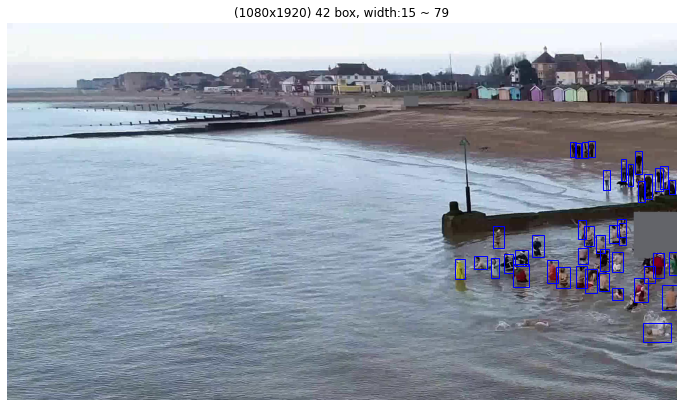

In [89]:
for example in tfds.as_numpy(dataset):
    #print(example[0].shape, example[1].shape)
    
    image = tf.cast(example[0], dtype=tf.float32)
    cls_bbox = example[1]        
    print('cls_bbox', cls_bbox)
    
    label = tf.cast(cls_bbox[:, 0],dtype=tf.int32)
    bbox = cls_bbox[:, 1:]
    h, w, c = image.shape    
    bbox_ori = bbox * np.array((h,w,h,w)).reshape((1, 4))
    
    visualize_detections_simple(image,bbox_ori,label)
    break

In [90]:
batch_size = 3 #6:OOM_E, [4,5]:OOM_W
autotune = tf.data.experimental.AUTOTUNE
train_dataset = dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

val_dataset = dataset_test.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

In [91]:
#label = tf.concat([box_target, cls_target], axis=-1)
for image, cbbox in val_dataset:         
    cls_gt = cbbox[:,:,-2]
    size_gt = cbbox[:,:,-1]
    
    small_count = np.sum(np.logical_and(cls_gt>0, np.logical_and(size_gt< 6*6, size_gt>=0.5)))
    positive_count = np.sum(cls_gt>0)
    print('cbbox', cbbox.shape, np.min(size_gt), np.mean(size_gt), np.max(size_gt), small_count, positive_count)
    print(np.sum(cls_gt == -3.0), np.sum(cls_gt == -2.0), np.sum(cls_gt == -1.0), np.sum(cls_gt == 0.0), np.sum(cls_gt == 1.0))
    break
    

cbbox (3, 40800, 6) 1e-16 601.8638 9898.666 15 598
0 115 121687 0 598


In [92]:
loss_list = []
loss_var_list = []
load_weight()
print(len(input_list_train))

latest_checkpoint retinanet/rect_anchor
53


In [604]:
epochs = 1000
hist = model.fit(
    train_dataset.take(1000),
    validation_data=val_dataset.take(1000),#val_dataset.take(2)
    epochs=epochs,
    callbacks=callbacks_list,#callbacks_list
    verbose=1,
)

Epoch 1/1000
      2/Unknown - 0s 203ms/step - loss: 5.3505 - recall: 0.0496 - precision: 0.0103WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1586s vs `on_train_batch_end` time: 0.2472s). Check your callbacks.
17/17 [==============================] - 14s 826ms/step - loss: 5.2219 - recall: 0.0301 - precision: 0.0080 - val_loss: 7.2775 - val_recall: 0.0176 - val_precision: 0.0071
Epoch 2/1000
17/17 [==============================] - 16s 925ms/step - loss: 5.2039 - recall: 0.0298 - precision: 0.0083 - val_loss: 7.2341 - val_recall: 0.0180 - val_precision: 0.0070
Epoch 3/1000
17/17 [==============================] - 15s 865ms/step - loss: 5.2551 - recall: 0.0303 - precision: 0.0083 - val_loss: 7.2994 - val_recall: 0.0189 - val_precision: 0.0068
Epoch 4/1000
17/17 [==============================] - 14s 828ms/step - loss: 5.2186 - recall: 0.0271 - precision: 0.0082 - val_loss: 7.3267 - val_recall: 0.0159 - val_precision: 0.0073
Ep

KeyboardInterrupt: 

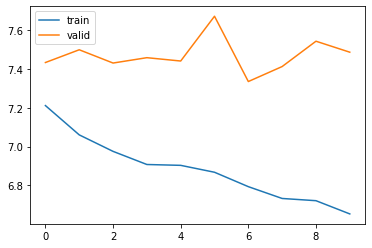

In [556]:
loss_list.extend(hist.history['loss'])
loss_var_list.extend(hist.history['val_loss'])

plt.plot(np.array(loss_list).reshape([-1]),label='train')
plt.plot(np.array(loss_var_list).reshape([-1]),label='valid')
plt.legend()

In [93]:
is_load = False
if is_load:
    weights_dir = model_dir#"data"
    latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
    print('latest_checkpoint', latest_checkpoint)
    model.load_weights(latest_checkpoint)

image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.2, nms_iou_threshold=0.1)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, jitter=None)
    return tf.expand_dims(image, axis=0), ratio

In [94]:
def check_test(test_datas, bboxs_label):
    i = 0
    for image, cbbox in test_datas: 
        if np.random.rand()<0.3:
            i+=1
            continue

        bbox_annotation = bboxs_label[i]
        scale = np.array(image.shape[:2])
        scale = np.reshape(scale, [1, 2])
        scale = np.concatenate((scale, scale), 1)
        gt_bbox = bbox_annotation[ :, 1:] * scale
        input_image, ratio = prepare_image(image)
        detections = inference_model.predict(input_image)        
        num_detections = detections.valid_detections[0]
        print('num_detections', num_detections, image.shape)
        
        #print('detections.nmsed_boxes[0][:num_detections] / ratio', detections.nmsed_boxes[0][:num_detections] / ratio)
        #[725.67  18.77 729.72  27.03]
        class_names = [WATER_CLASSES[(int(x))] for x in detections.nmsed_classes[0][:num_detections]    ]
        visualize_detections(
            image,
            detections.nmsed_boxes[0][:num_detections] / ratio,
            class_names,
            detections.nmsed_scores[0][:num_detections],
            boxes_gt=gt_bbox
        )
        i+=1
        if i>10:
            break
    

num_detections 70 (1080, 1920, 3)


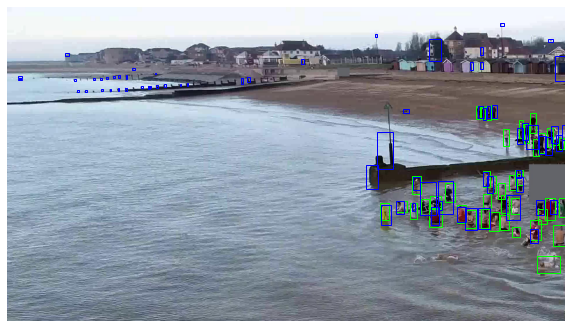

num_detections 22 (540, 960, 3)


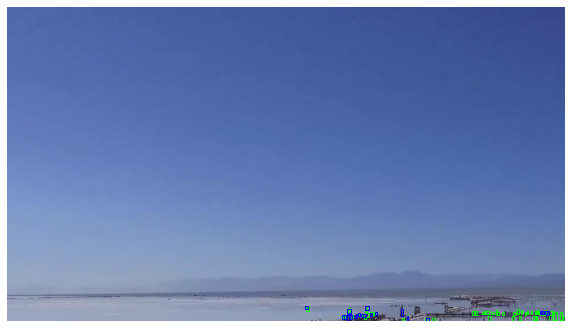

num_detections 45 (1080, 1920, 3)


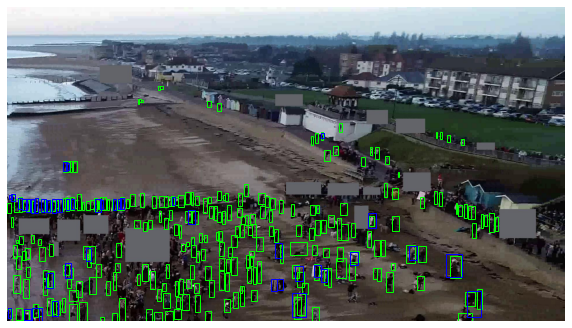

num_detections 15 (1080, 1920, 3)


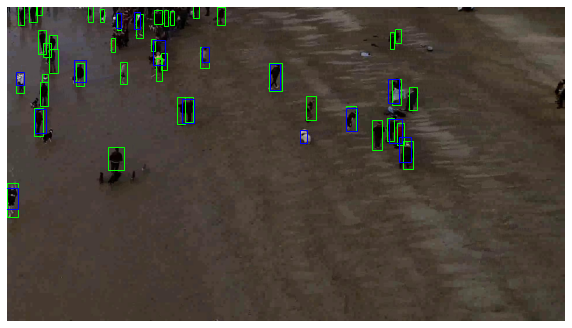

num_detections 106 (1080, 1920, 3)


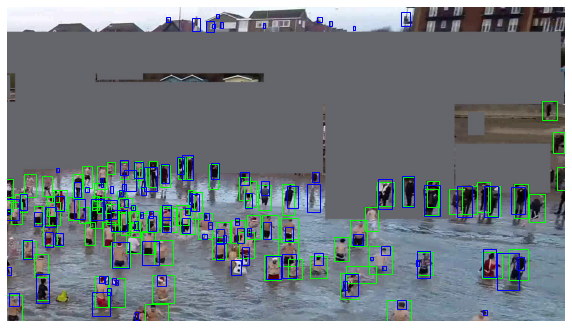

num_detections 169 (540, 960, 3)


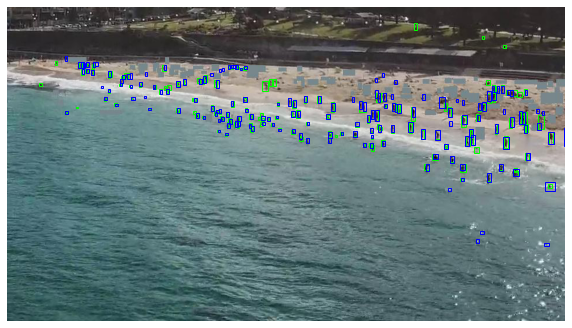

num_detections 35 (536, 960, 3)


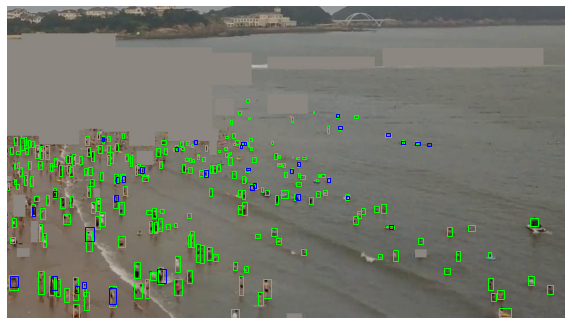

num_detections 75 (1080, 1920, 3)


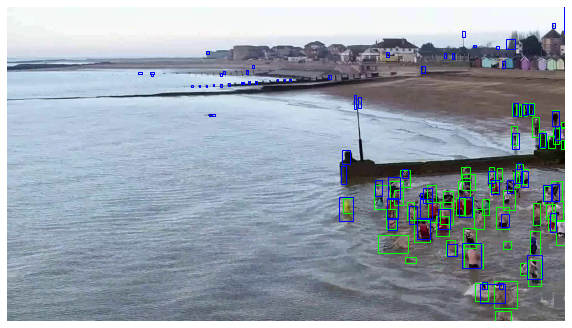

In [95]:
check_test(dataset, bbox_list_train)

In [65]:
check_test(dataset_test, bbox_list_test)

num_detections 8 (1080, 1920, 3) 43.388412 1280.6676


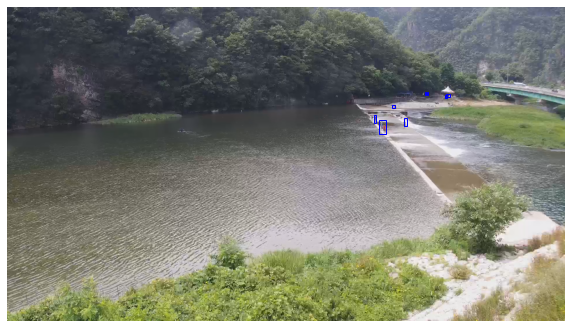

In [50]:
for i in range(len(water_images)):
    image = water_images[i]
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)        
    num_detections = detections.valid_detections[0]
    bbox = detections.nmsed_boxes[0][:num_detections] / ratio
    bbox_area = np.prod(bbox[:, 2:] - bbox[:, 0:2], axis=1)
    bbox_area_min = np.min(bbox_area)
    bbox_area_max = np.max(bbox_area)
    print('num_detections', num_detections, image.shape, bbox_area_min, bbox_area_max)

    #print('detections.nmsed_boxes[0][:num_detections] / ratio', detections.nmsed_boxes[0][:num_detections] / ratio)
    #[725.67  18.77 729.72  27.03]
    class_names = [WATER_CLASSES[(int(x))] for x in detections.nmsed_classes[0][:num_detections]    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections]        
    )
    break

In [ ]:
for image, cbbox in dataset: 
    bbox = cbbox[:, :4]
    cls = cbbox[:, 0]
    print('cbbox', cbbox.shape)
    break